In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=15.6s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load other data 

In [5]:
dic_data_raw = {}
dic_data_processed = {}

# Aizarani et al. Liver atlas
dic_data_raw['aizarani'] = dl.load_aizarani_raw_data(opt='raw')
dic_data_processed['aizarani'] = dl.load_aizarani_raw_data(opt='processed')

DNAME_LIST = ['aizarani']

### Load gene annotation

In [6]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [7]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Compute TRS

In [8]:
# Precompute statistics 
md.compute_stats(data_facs_ct)

In [9]:
##### Tissue and tissue-cell type list
TISSUE_LIST = list(set(data_facs_ct.obs['tissue']))
TISSUE_LIST.sort()
TC_LIST = list(set(data_facs_ct.obs['tissue_celltype']))
TC_LIST.sort()
print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(TISSUE_LIST), len(TC_LIST)))

# Get GWAS trait geneset
TRAIT_LIST = ['PASS_Schizophrenia_Ruderfer2018',
              'PASS_BipolarDisorder_Ruderfer2018',
              'PASS_Alzheimers_Jansen2019', 
              'PASS_AdultOnsetAsthma_Ferreira2019',
              'PASS_Coronary_Artery_Disease', 
              'PASS_LargeArteryStroke_Malik2018', 
              'PASS_HDL', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_Lupus', 
              'PASS_IBD_deLange2017', 
              'PASS_Type_1_Diabetes', 
              'PASS_Type_2_Diabetes']

dic_tgs = {}
for trait in TRAIT_LIST:
    # Find FDR<0.1 genes 
    temp_df = df_geneannot[[trait]].copy()
    temp_df.columns = ['z_score']
    temp_df['p_val'] = 1 - sp.stats.norm.cdf(temp_df['z_score'].values)
    temp_df['fdr'] = multipletests(temp_df['p_val'].values, method='fdr_bh')[1]
    dic_tgs[trait] = list(temp_df.index[temp_df['fdr']<0.1])
    
# Random gene set
for i_rep in range(5):
    dic_tgs['Random%d'%i_rep] = list(np.random.choice(data_facs_ct.var_names, size=500))
    TRAIT_LIST.append('Random%d'%i_rep)
    
for trait in TRAIT_LIST:
    print('# %-40s n_gene=%d'%(trait, len(dic_tgs[trait])))

# facs data: n_tissue=23 n_tissue_celltype=207
# PASS_Schizophrenia_Ruderfer2018          n_gene=1720
# PASS_BipolarDisorder_Ruderfer2018        n_gene=685
# PASS_Alzheimers_Jansen2019               n_gene=298
# PASS_AdultOnsetAsthma_Ferreira2019       n_gene=208
# PASS_Coronary_Artery_Disease             n_gene=164
# PASS_LargeArteryStroke_Malik2018         n_gene=25
# PASS_HDL                                 n_gene=527
# PASS_LDL                                 n_gene=460
# PASS_Rheumatoid_Arthritis                n_gene=286
# PASS_Lupus                               n_gene=320
# PASS_IBD_deLange2017                     n_gene=1703
# PASS_Type_1_Diabetes                     n_gene=336
# PASS_Type_2_Diabetes                     n_gene=71
# Random0                                  n_gene=500
# Random1                                  n_gene=500
# Random2                                  n_gene=500
# Random3                                  n_gene=500
# Random4                          

In [10]:
# Obtain TRS
dic_trs = {}
start_time = time.time()
for trait in TRAIT_LIST:
    
    # mean, n_genes
    md.score_cell(data_facs_ct, dic_tgs[trait], suffix='',
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                  n_ctrl=10, n_genebin=200, cov_list=['mean', 'n_genes'],
                  return_list=['trs', 'trs_ep', 'trs_ez'], verbose=False)
    
    dic_trs['%s;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
    dic_trs['%s;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
    dic_trs['%s;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()
    
    # mean, n_genes
    md.score_cell(data_facs_ct, dic_tgs[trait], suffix='',
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='debug',
                  n_ctrl=100, n_genebin=200, cov_list=None,
                  return_list=['trs', 'trs_ep', 'trs_ez'], verbose=False)
    
    dic_trs['%s;new_trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
    dic_trs['%s;new_trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
    dic_trs['%s;new_trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()
    
    print('#%-40s time=%0.1fs'%(trait,time.time()-start_time))

#PASS_Schizophrenia_Ruderfer2018          time=313.0s
#PASS_BipolarDisorder_Ruderfer2018        time=558.1s
#PASS_Alzheimers_Jansen2019               time=780.4s
#PASS_AdultOnsetAsthma_Ferreira2019       time=987.9s
#PASS_Coronary_Artery_Disease             time=1190.1s
#PASS_LargeArteryStroke_Malik2018         time=1355.4s
#PASS_HDL                                 time=1506.3s
#PASS_LDL                                 time=1619.1s
#PASS_Rheumatoid_Arthritis                time=1731.0s
#PASS_Lupus                               time=1844.2s
#PASS_IBD_deLange2017                     time=2007.2s
#PASS_Type_1_Diabetes                     time=2118.8s
#PASS_Type_2_Diabetes                     time=2211.0s
#Random0                                  time=2326.4s
#Random1                                  time=2443.3s
#Random2                                  time=2560.2s
#Random3                                  time=2673.9s
#Random4                                  time=2790.4s


In [11]:
# Number of rejections 
for config in ['trs_ep', 'new_trs_ep']:
    for trait in TRAIT_LIST:
        v_p = dic_trs['%s;%s'%(trait, config)]
        v_fdr = multipletests(v_p, method='fdr_bh')[1]
        print('# %s %-40s n_rej=%d'%(config, trait, (v_fdr<0.2).sum()))
    print('')

# trs_ep PASS_Schizophrenia_Ruderfer2018          n_rej=172
# trs_ep PASS_BipolarDisorder_Ruderfer2018        n_rej=78
# trs_ep PASS_Alzheimers_Jansen2019               n_rej=0
# trs_ep PASS_AdultOnsetAsthma_Ferreira2019       n_rej=0
# trs_ep PASS_Coronary_Artery_Disease             n_rej=14
# trs_ep PASS_LargeArteryStroke_Malik2018         n_rej=0
# trs_ep PASS_HDL                                 n_rej=0
# trs_ep PASS_LDL                                 n_rej=639
# trs_ep PASS_Rheumatoid_Arthritis                n_rej=0
# trs_ep PASS_Lupus                               n_rej=0
# trs_ep PASS_IBD_deLange2017                     n_rej=0
# trs_ep PASS_Type_1_Diabetes                     n_rej=115
# trs_ep PASS_Type_2_Diabetes                     n_rej=0
# trs_ep Random0                                  n_rej=0
# trs_ep Random1                                  n_rej=0
# trs_ep Random2                                  n_rej=0
# trs_ep Random3                                  n_rej=0
# trs_

### Tissue-trait association

/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()


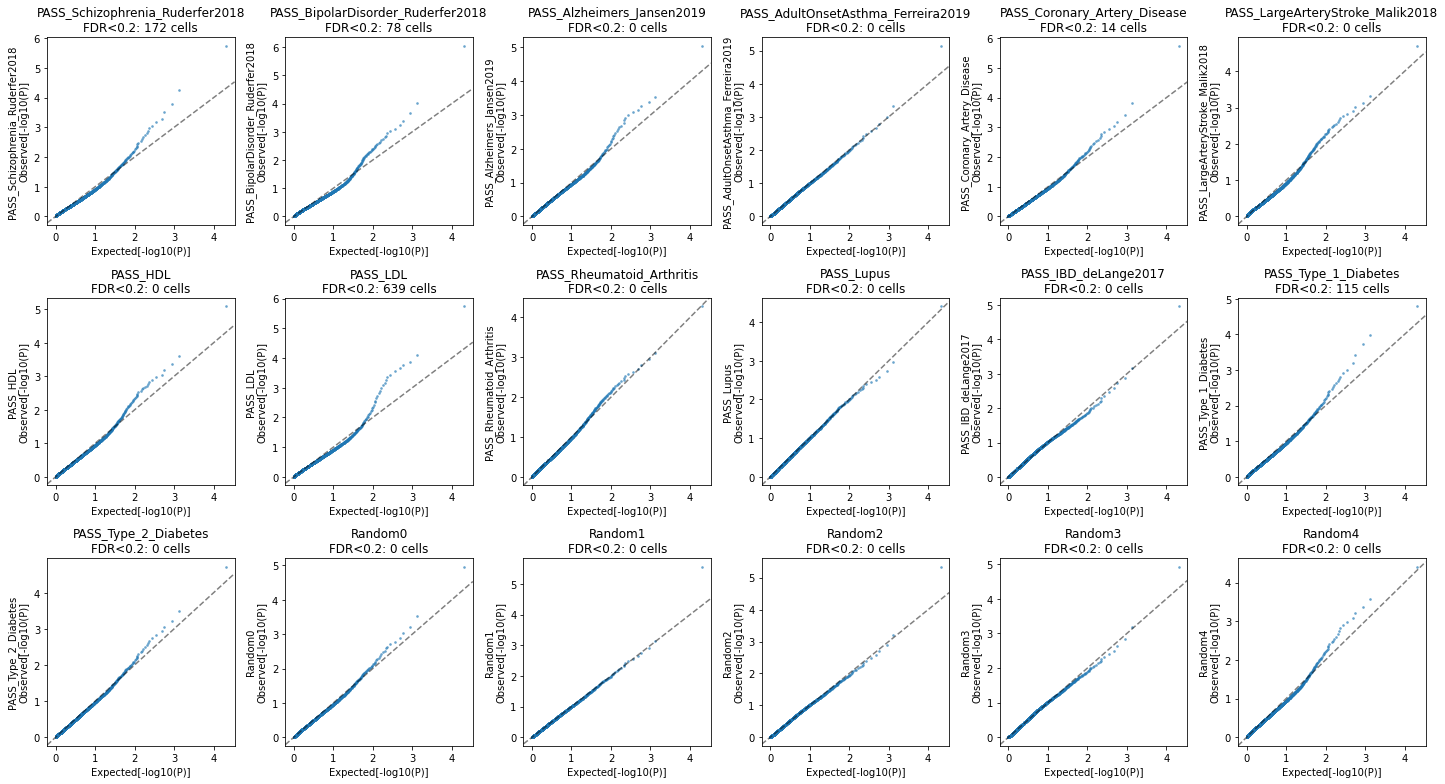

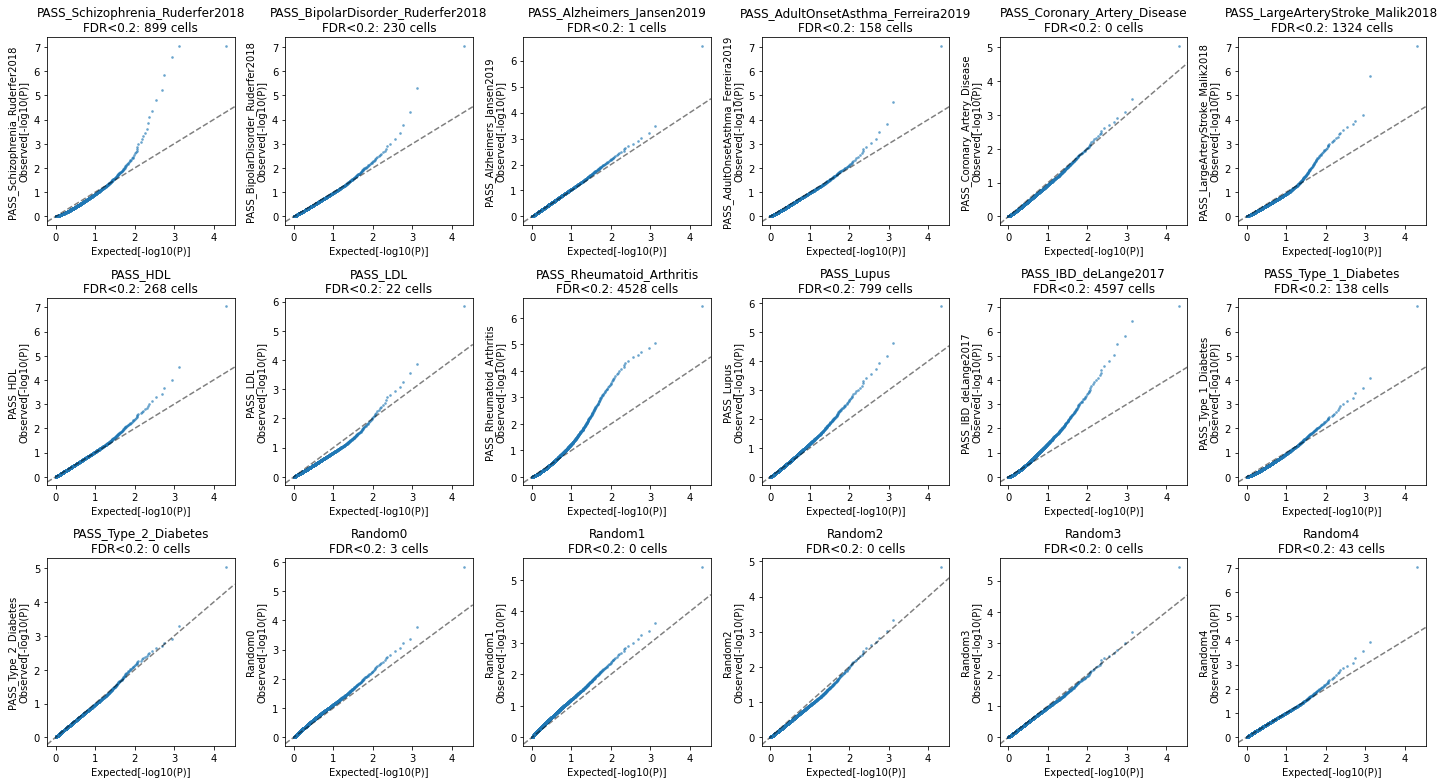

In [13]:
# QQ-plot 
plot_config_list = ['trs_ep', 'new_trs_ep']
plot_trait_list = TRAIT_LIST

normal_x = np.random.rand(10000)
normal_x = -np.log10(normal_x)

for i_config,config in enumerate(plot_config_list):
    plt.figure(figsize=[20, 2+3*len(plot_trait_list)/6])
    for i_trait,trait in enumerate(plot_trait_list): 
        
        v_p = dic_trs['%s;%s'%(trait,config)]
        v_fdr = multipletests(v_p, method='fdr_bh')[1]
        v_nlogp = -np.log10(v_p)
        
        plt.subplot(np.ceil(len(plot_trait_list)/6), 6,i_trait+1)
        util.qqplot(x=normal_x, y=v_nlogp, quantiles=2000, s=3, alpha=0.5)
        plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
        
        plt.title('%s\nFDR<0.2: %d cells'%(trait,(v_fdr<0.2).sum()))
        plt.ylabel('%s\nObserved[-log10(P)]'%trait)
        plt.xlabel('Expected[-log10(P)]')
        
    plt.tight_layout()
#     plt.savefig('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/result/trait_assoc_090220/qqplot_%s.pdf'%config)
    plt.show()

In [41]:
# Find number of associated cells for each tissue/tissue_celltype

dic_assoc = {'tissue': pd.DataFrame(index=TISSUE_LIST, columns=TRAIT_LIST, data=0),
             'tissue-celltype': pd.DataFrame(index=TC_LIST, columns=TRAIT_LIST, data=0)}

df_obs = data_facs_ct.obs.copy()

for trait in TRAIT_LIST:
    
    v_p = dic_trs['%s;trs_ep'%trait]
    v_fdr = multipletests(v_p, method='fdr_bh')[1]
    
    # tissue
    temp_df = df_obs.loc[v_fdr<0.2].copy()
    temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue'].loc[temp_df.index, trait] = temp_df['cell'].values
    
    # tissue-cell
    temp_df = df_obs.loc[v_fdr<0.2].copy().copy()
    temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue-celltype'].loc[temp_df.index, trait] = temp_df['cell'].values

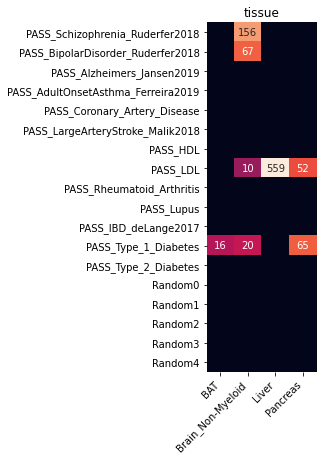

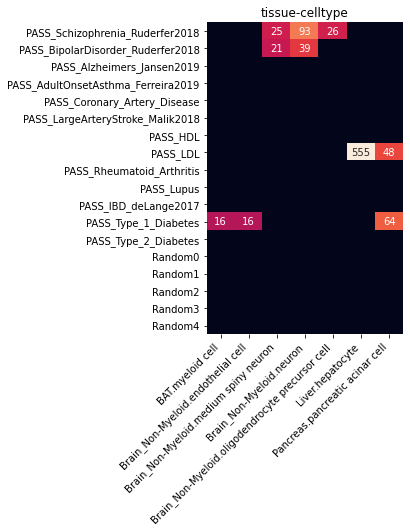

In [43]:
def num2str(x):
    if x>1000:
        return '%0.1fk'%(x/1000)
    elif x>0:
        return '%d'%x
    else:
        return ''
    
for term in dic_assoc.keys():

    df_plot = dic_assoc[term].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>10]
    df_plot = df_plot.T
    df_plot[df_plot<10] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1*('tissue-celltype' in term)])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(term)
    plt.tight_layout()
    plt.show()

In [44]:
# Find number of associated cells for each tissue/tissue_celltype

dic_assoc = {'tissue': pd.DataFrame(index=TISSUE_LIST, columns=TRAIT_LIST, data=0),
             'tissue-celltype': pd.DataFrame(index=TC_LIST, columns=TRAIT_LIST, data=0)}

df_obs = data_facs_ct.obs.copy()

for trait in TRAIT_LIST:
    
    v_p = dic_trs['%s;new_trs_ep'%trait]
    v_fdr = multipletests(v_p, method='fdr_bh')[1]
    
    # tissue
    temp_df = df_obs.loc[v_fdr<0.2].copy()
    temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue'].loc[temp_df.index, trait] = temp_df['cell'].values
    
    # tissue-cell
    temp_df = df_obs.loc[v_fdr<0.2].copy().copy()
    temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue-celltype'].loc[temp_df.index, trait] = temp_df['cell'].values

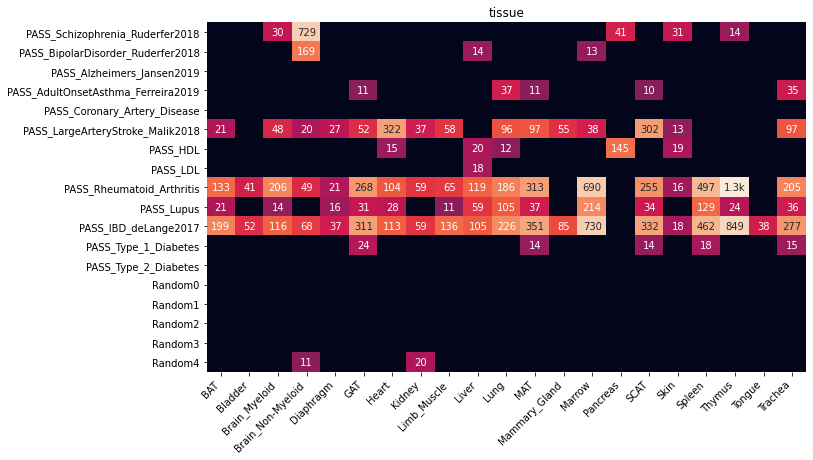

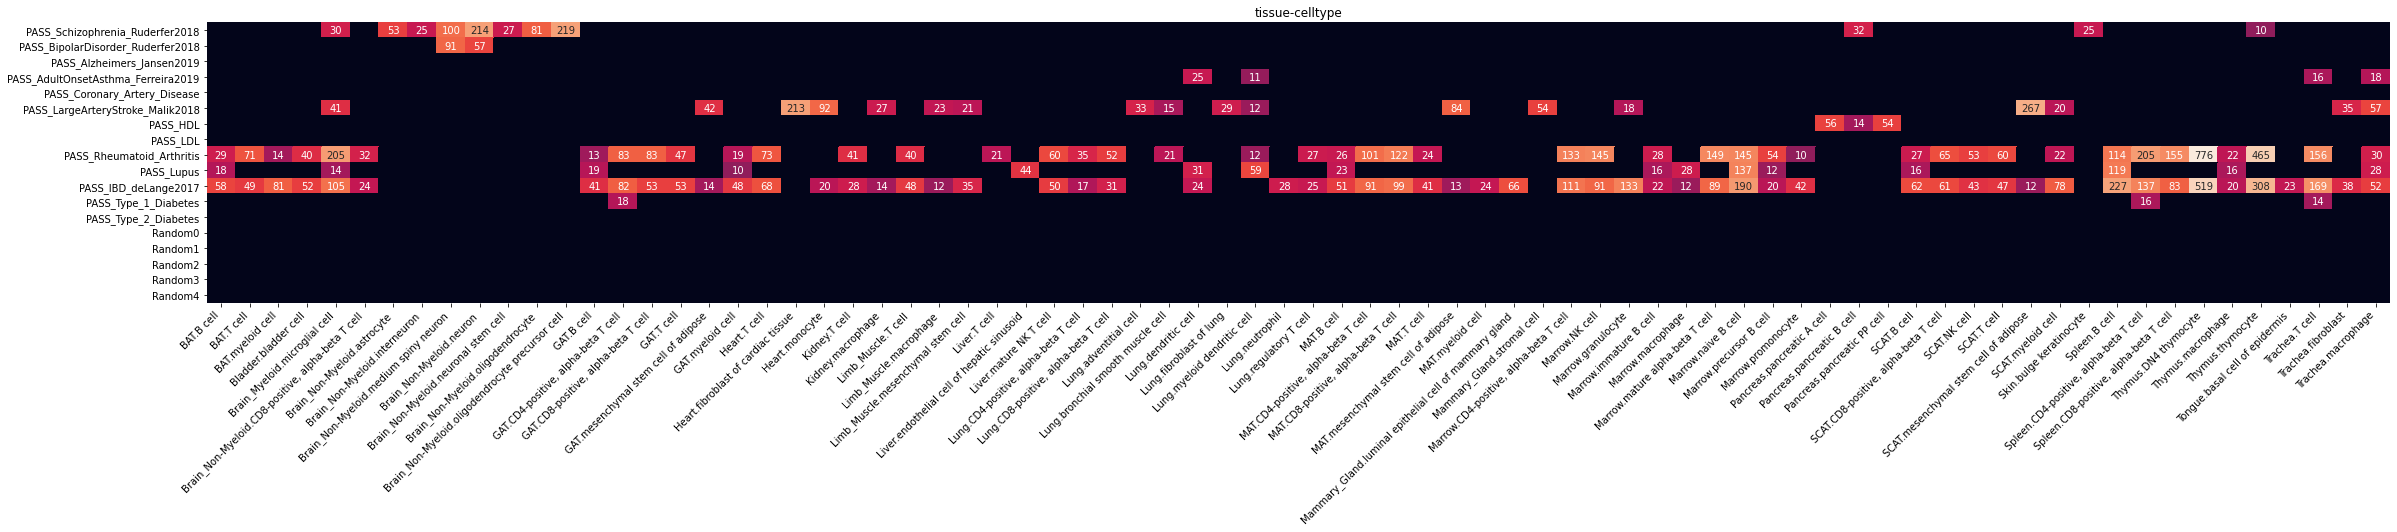

In [47]:
def num2str(x):
    if x>1000:
        return '%0.1fk'%(x/1000)
    elif x>0:
        return '%d'%x
    else:
        return ''
    
for term in dic_assoc.keys():

    df_plot = dic_assoc[term].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>20]
    df_plot = df_plot.T
    df_plot[df_plot<10] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1*('tissue-celltype' in term)])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(term)
    plt.tight_layout()
    plt.show()

### Per-tissue TRS distribution 

### Heterogeneity pattern

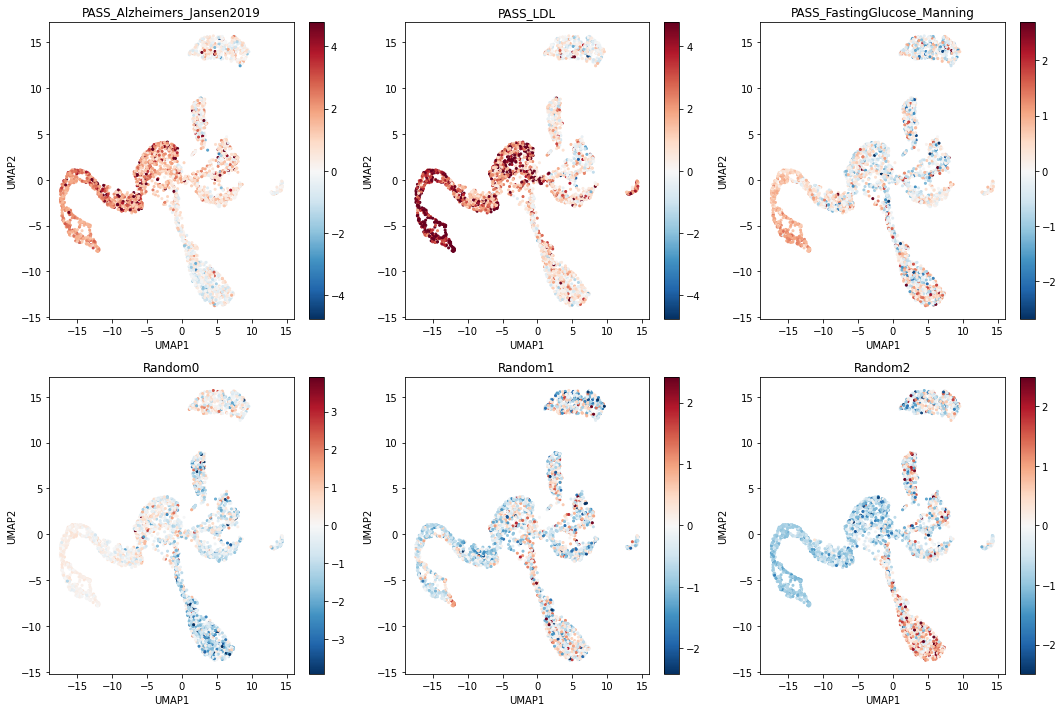

In [84]:
plot_list = [['Liver', TRAIT_LIST]]

for tissue,trait_plot_list in plot_list:
    
    adata_small = dic_data_facs[tissue].copy()    
    df_plot = pd.DataFrame(index=adata_small.obs.index)
    df_plot['UMAP1'] = adata_small.obsm['X_umap'][:,0]
    df_plot['UMAP2'] = adata_small.obsm['X_umap'][:,1]
    
    # Trait TRS plot
    plt.figure(figsize=[15,10])
    for i_trait,trait in enumerate(trait_plot_list):
        
        plt.subplot(2,3,i_trait+1)
        temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
        temp_df[trait] = dic_trs['%s;trs_ez'%(trait)]
        df_plot = df_plot.join(temp_df[trait])
            
        
        max_ = np.quantile(np.absolute(df_plot[trait].values), 0.99)
        min_ = np.quantile(np.absolute(df_plot[trait].values), 0.01)
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[trait],
                    cmap='RdBu_r', vmax=max_, vmin=-max_, s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s'%trait)
        
    plt.tight_layout()
    plt.show()

### Old code

In [ ]:
dic_mapping_m2h = {df_orth['name'].values[x]:df_orth['incoming'].values[x] for x in np.arange(df_orth.shape[0])}

In [31]:
dic_data_raw[dname].obs['n_genes'] = (dic_data_raw[dname].X>0).sum(axis=1)

In [74]:
# Obtain TRS: other data 
dic_trs_other = {}
start_time = time.time()
for dname in DNAME_LIST:
    dic_trs_other[dname] = {}
    for trait in TRAIT_LIST:

        ind_select = (dic_magma[trait]['fdr'].values<0.1)
        gene_list = dic_magma[trait].index[ind_select]
        gene_list = [dic_mapping_m2h[x] for x in gene_list]
        gene_list = list(set(gene_list))

        # mean, n_genes
        md.score_cell(dic_data_raw[dname], gene_list, suffix='',
                      ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                      n_ctrl=10, n_genebin=200, cov_list=['mean', 'n_genes'],
                      return_list=['trs', 'trs_ez'], verbose=True)

        dic_trs_other[dname]['%s;trs'%(trait)] = dic_data_raw[dname].obs['trs'].values.copy()
        dic_trs_other[dname]['%s;trs_ez'%(trait)] = dic_data_raw[dname].obs['trs_ez'].values.copy()

        print('#%-40s n_gene=%d time=%0.1fs'%(trait,len(gene_list), time.time()-start_time))

# score_cell: suffix=, ctrl_opt=mean_match, trs_opt=vst, bc_opt=empi
# score_cell: n_ctrl=10, n_genebin=200
# score_cell: trait geneset,  271/298 genes,  mean_exp=1.75e-01   
# score_cell: ctrl0 geneset,  271 genes,      mean_exp=1.74e-01   
# score_cell: ctrl1 geneset,  271 genes,      mean_exp=1.73e-01   
# score_cell: ctrl2 geneset,  271 genes,      mean_exp=1.74e-01   
# score_cell: ctrl3 geneset,  271 genes,      mean_exp=1.76e-01   
# score_cell: ctrl4 geneset,  271 genes,      mean_exp=1.74e-01   
# score_cell: ctrl5 geneset,  271 genes,      mean_exp=1.70e-01   
# score_cell: ctrl6 geneset,  271 genes,      mean_exp=1.72e-01   
# score_cell: ctrl7 geneset,  271 genes,      mean_exp=1.72e-01   
# score_cell: ctrl8 geneset,  271 genes,      mean_exp=1.73e-01   
# score_cell: ctrl9 geneset,  271 genes,      mean_exp=1.72e-01   
#PASS_Alzheimers_Jansen2019               n_gene=298 time=1.6s
# score_cell: suffix=, ctrl_opt=mean_match, trs_opt=vst, bc_opt=empi
# score_cell: n_ctrl=10

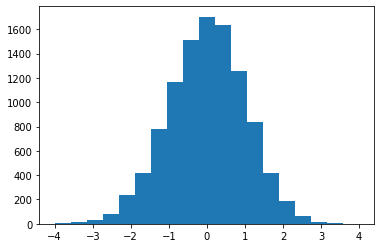

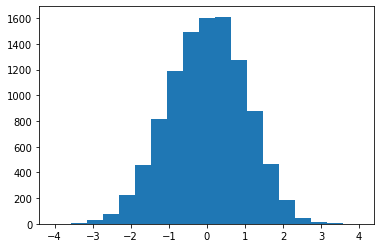

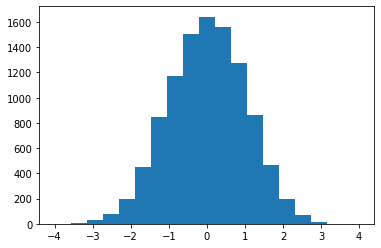

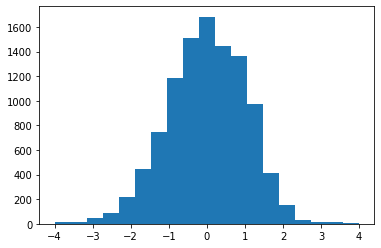

In [76]:

for trait in TRAIT_LIST:
    plt.figure()
    plt.hist(dic_trs_other[dname]['%s;trs_ez'%(trait)], bins=np.linspace(-4,4,20))
    plt.show()

In [80]:
dic_data_processed[dname].obs['n_genes'] = (dic_data_raw[dname].X>0).sum(axis=1)

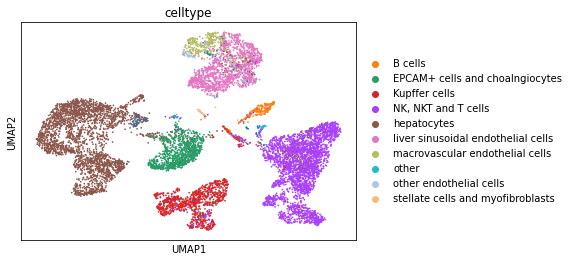

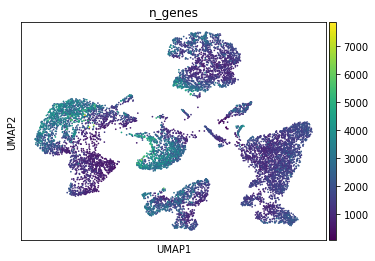

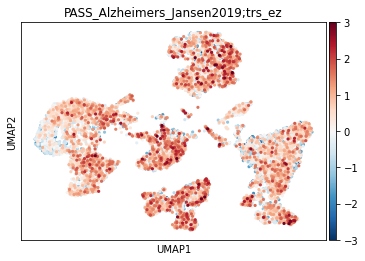

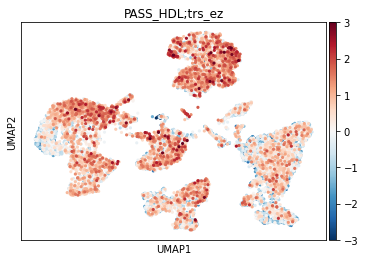

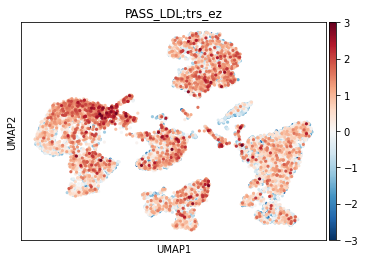

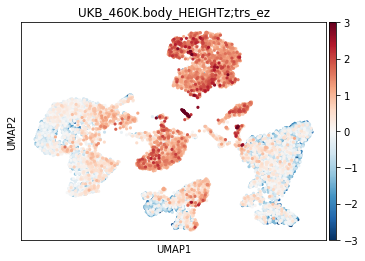

In [81]:
sc.pl.umap(dic_data_processed[dname], color='celltype')
sc.pl.umap(dic_data_processed[dname], color='n_genes')

for trait in TRAIT_LIST:
    dic_data_processed[dname].obs['%s;trs_ez'%(trait)] = dic_trs_other[dname]['%s;trs_ez'%(trait)]
    sc.pl.umap(dic_data_processed[dname], color='%s;trs_ez'%(trait),
               cmap='RdBu_r', s=40, vmax=3, vmin=-3)

In [73]:
for trait in TRAIT_LIST:
    
    temp_df = dic_data_raw[dname].obs[['cluster_id', 'celltype', 'cell_id']].copy()
    temp_df['z_score'] = dic_trs_other[dname]['%s;trs_ez'%(trait)]    
    temp_df['p_val'] = 1 - sp.stats.norm.cdf(temp_df['z_score'].values)
    temp_df['fdr'] = multipletests(temp_df['p_val'].values, method='fdr_bh')[1]
    temp_df = temp_df.loc[temp_df['fdr']<0.4]
    temp_df = temp_df.groupby('celltype').agg({'cell_id':len})
    temp_df = temp_df.loc[temp_df['cell_id']>0]
    
    print('##################################################')
    print(trait)
    print(temp_df)
    print((''))
    
#     break

##################################################
PASS_Alzheimers_Jansen2019
Empty DataFrame
Columns: [cell_id]
Index: []

##################################################
PASS_HDL
Empty DataFrame
Columns: [cell_id]
Index: []

##################################################
PASS_LDL
Empty DataFrame
Columns: [cell_id]
Index: []

##################################################
UKB_460K.body_HEIGHTz
                                   cell_id
celltype                                  
other endothelial cells                2.0
stellate cells and myofibroblasts     11.0



### TRS pattern

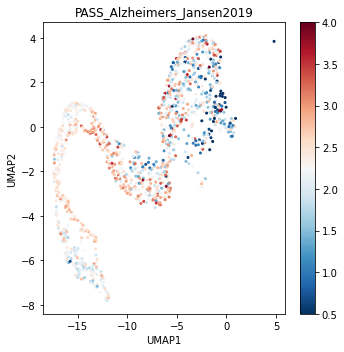

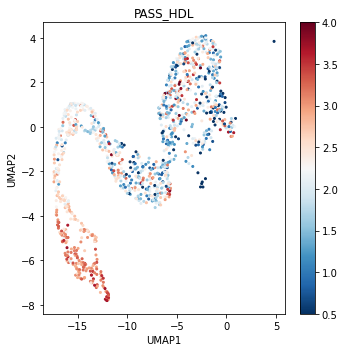

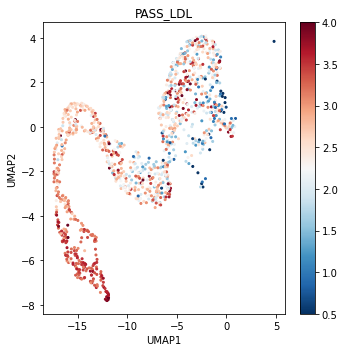

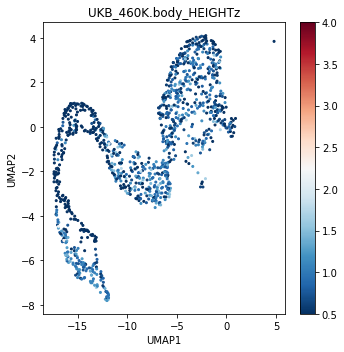

In [10]:
plot_list = [['Liver.hepatocyte', TRAIT_LIST]]

for analyte,trait_plot_list in plot_list:
    
    tissue,celltype = analyte.split('.')
    ind_select = (dic_data_facs[tissue].obs['tissue']==tissue)&\
                    (dic_data_facs[tissue].obs['cell_ontology_class']==celltype)
    adata_small = dic_data_facs[tissue][ind_select,:].copy()
    
    df_plot = pd.DataFrame(index=adata_small.obs.index)
    df_plot['UMAP1'] = adata_small.obsm['X_umap'][:,0]
    df_plot['UMAP2'] = adata_small.obsm['X_umap'][:,1]
    
    # Trait TRS plot
    for trait in trait_plot_list:
    
        temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
        temp_df['trs_ez'] = dic_trs['%s;trs_ez'%(trait)]
        df_plot['trs_ez'] = temp_df.loc[df_plot.index, 'trs_ez']
            
        plt.figure(figsize=[5,5])
        max_ = np.quantile(np.absolute(df_plot['trs_ez'].values), 0.99)
        min_ = np.quantile(np.absolute(df_plot['trs_ez'].values), 0.01)
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['trs_ez'],
                    cmap='RdBu_r', vmax=4, vmin=0.5, s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s'%trait)
        plt.tight_layout()
        plt.show()

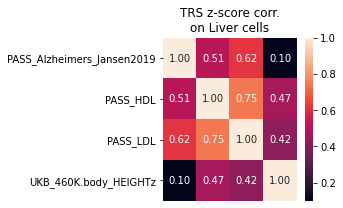

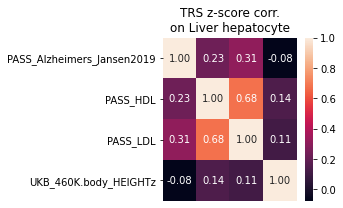

In [11]:
### Correlation between different covariate control methods 
ind_select = (data_facs_ct.obs['tissue']=='Liver')
df_plot = pd.DataFrame(index=data_facs_ct.obs[ind_select])
for trait in TRAIT_LIST:
    df_plot[trait] = dic_trs['%s;trs_ez'%(trait)][ind_select]

df_plot = df_plot.corr()
plt.figure(figsize=[3,3])
sns.heatmap(df_plot, annot=df_plot, fmt='0.2f', xticklabels=False)
plt.title('TRS z-score corr.\non Liver cells')
plt.show()

ind_select = (data_facs_ct.obs['tissue']=='Liver')&(data_facs_ct.obs['cell_ontology_class']=='hepatocyte')
df_plot = pd.DataFrame(index=data_facs_ct.obs[ind_select])
for trait in TRAIT_LIST:
    df_plot[trait] = dic_trs['%s;trs_ez'%(trait)][ind_select]

df_plot = df_plot.corr()
plt.figure(figsize=[3,3])
sns.heatmap(df_plot, annot=df_plot, fmt='0.2f', xticklabels=False)
plt.title('TRS z-score corr.\non Liver hepatocyte')
plt.show()

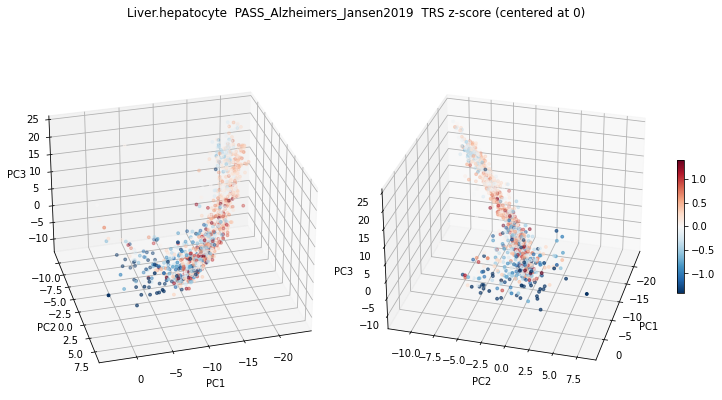

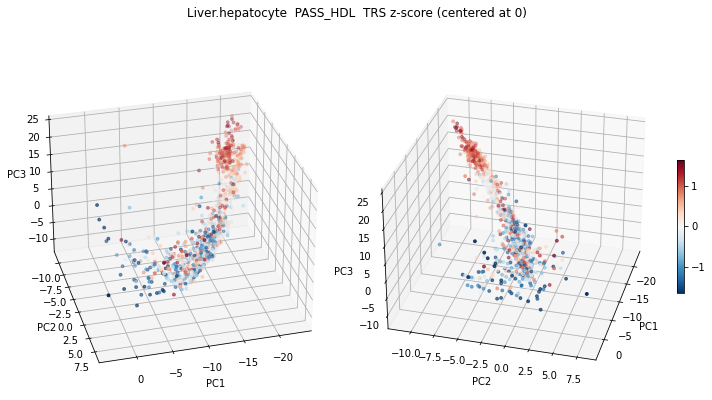

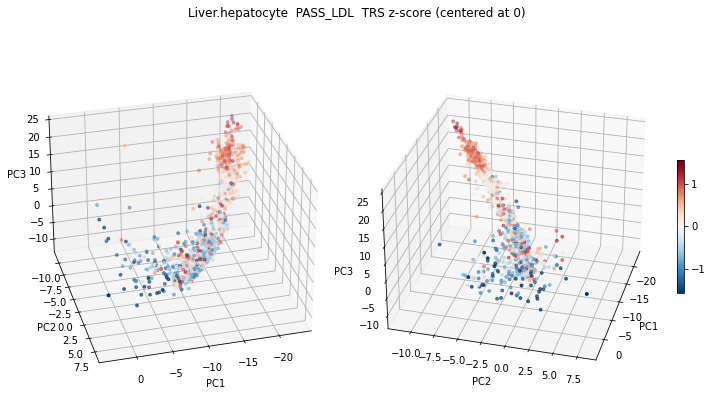

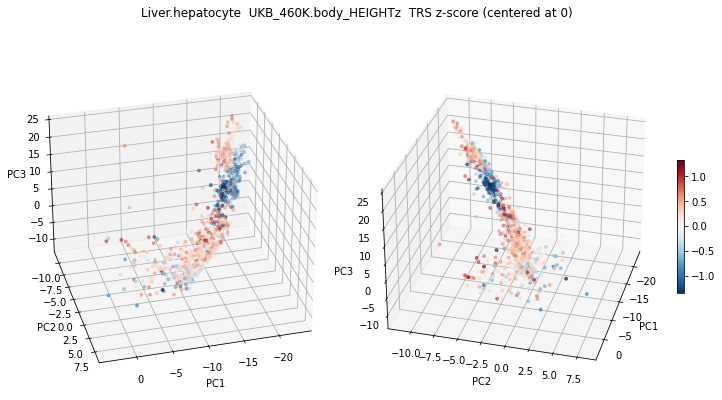

In [26]:
# 3d plots
from mpl_toolkits import mplot3d

plot_list = [['Liver.hepatocyte', TRAIT_LIST]]

for analyte,trait_plot_list in plot_list:
    
    tissue,celltype = analyte.split('.')
    ind_select = (dic_data_facs[tissue].obs['tissue']==tissue)&\
                    (dic_data_facs[tissue].obs['cell_ontology_class']==celltype)
    adata_small = dic_data_facs[tissue][ind_select,:].copy()
    
    df_plot = pd.DataFrame(index=adata_small.obs.index)
    df_plot['PC1'] = adata_small.obsm['X_pca'][:,0]
    df_plot['PC2'] = adata_small.obsm['X_pca'][:,1]
    df_plot['PC3'] = adata_small.obsm['X_pca'][:,2]
    
    # Trait TRS plot
    for trait in trait_plot_list:
    
        temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
        temp_df['trs_ez'] = dic_trs['%s;trs_ez'%(trait)]
        df_plot['trs_ez'] = temp_df.loc[df_plot.index, 'trs_ez']
        
        df_plot['trs_ez'] = (df_plot['trs_ez']-df_plot['trs_ez'].mean())
    
        fig = plt.figure(figsize=[10,6])
        for iangle,angle in enumerate([75, 15]):
            
            ax = fig.add_subplot(1, 2, iangle+1, projection='3d')
            max_ = np.quantile(np.absolute(df_plot['trs_ez'].values), 0.95)
            p = ax.scatter(df_plot['PC1'], df_plot['PC2'],  df_plot['PC3'],
                           c=df_plot['trs_ez'], cmap='RdBu_r', vmax=max_, vmin=-max_, s=8)
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
            ax.set_zlabel('PC3')
            ax.view_init(30, angle)
            
            if iangle==1: fig.colorbar(p, fraction=0.02, pad=0)
        
        plt.suptitle('%s  %s  TRS z-score (centered at 0)'%(analyte, trait))
        plt.tight_layout()
        plt.show()
        
    break

### TRS-correlated genes 

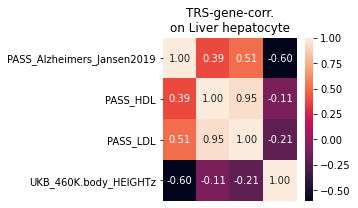

In [12]:
df_gene_corr = pd.DataFrame(index=data_facs_ct.var_names)
trs_name = 'trs_ez'

for trait in TRAIT_LIST:  
            
    # Liver hepatocyte
    ind_select = (data_facs_ct.obs['tissue']=='Liver')&\
                    (data_facs_ct.obs['cell_ontology_class']=='hepatocyte')
    temp_adata = data_facs_ct[ind_select,:].copy()
    temp_adata.obs['trs_ez'] = dic_trs['%s;trs_ez'%trait][ind_select]
    
    md.correlate_gene(temp_adata, trs_name=trs_name, corr_opt='pearson', cov_list=None)
    df_gene_corr['%s'%(trait)] = temp_adata.var[['trs_corr']].copy()
    
df_plot = df_gene_corr.corr()
plt.figure(figsize=[3,3])
sns.heatmap(df_plot, annot=df_plot, fmt='0.2f', xticklabels=False)
plt.title('TRS-gene-corr.\non Liver hepatocyte')
plt.show()

In [13]:
# Pathway analysis on TRS correlated genes 
dic_geneset= {}
all_gene_list = []
for trait in TRAIT_LIST:  
    df_gene_corr.sort_values(by=trait, ascending=False, inplace=True)
    print('### %s'%trait)
    print(list(df_gene_corr.index[0:10]))
    dic_geneset[trait] = list(df_gene_corr.index[0:100])
    all_gene_list += dic_geneset[trait]
    
dic_geneset['AD_only'] = list(set(dic_geneset['PASS_Alzheimers_Jansen2019'])
                              - set(dic_geneset['PASS_HDL'])
                              - set(dic_geneset['PASS_LDL']))
dic_geneset['LDL_HDL_only'] = list(set(dic_geneset['PASS_LDL']).union(set(dic_geneset['PASS_HDL'])) - 
                                   set(dic_geneset['PASS_Alzheimers_Jansen2019']))

for gs in dic_geneset.keys():
    print(gs, len(dic_geneset[gs]))


### PASS_Alzheimers_Jansen2019
['Apoa2', 'Apoc4', 'Apoc1', 'Ttr', 'Azgp1', 'Fabp1', 'Rbp4', 'Serpina1b', 'Apoc3', 'Mgst1']
### PASS_HDL
['F2', 'Apoa5', 'Apob', 'Itih4', 'Plg', 'Apoe', 'Alb', 'Fga', 'Cfb', 'Slc27a5']
### PASS_LDL
['Apoa5', 'Apob', 'Itih1', 'Plg', 'Itih3', 'F2', 'Cfb', 'Apoe', 'Fga', 'Alb']
### UKB_460K.body_HEIGHTz
['Aldh2', 'Ass1', 'Mpst', 'Ptms', 'Aldh1b1', 'Gm5506', 'Jund', 'Aes', 'Rn45s', 'Ppp1r37']
PASS_Alzheimers_Jansen2019 100
PASS_HDL 100
PASS_LDL 100
UKB_460K.body_HEIGHTz 100
AD_only 88
LDL_HDL_only 100


In [55]:
dic_pathway = {}
for term in dic_geneset.keys():
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism='mmusculus', query=dic_geneset[term],
                            sources=['KEGG'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.001,
                            background=list(data_facs_ct.var_names))
    dic_pathway[term] = df_pathway.copy()
    print(term)
    
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('./trs_corr.111720.xlsx', engine='xlsxwriter')
for term in dic_pathway.keys():
    temp_df = dic_pathway[term].copy()
    ind_select = (temp_df['term_size']<1000)&(temp_df['precision']>0.1)
    temp_df.loc[ind_select].to_excel(writer, sheet_name=term[:30])
writer.save()

PASS_Alzheimers_Jansen2019
PASS_HDL
PASS_LDL
UKB_460K.body_HEIGHTz
AD_only
LDL_HDL_only


### Compare with other gene sets

In [14]:
dic_geneset_comp = {}

# Load KEGG ALZ geneset
fname = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'\
        'msigdb_v7.1_files_to_download_locally/msigdb_v7.1_GMTs/c2.cp.kegg.v7.1.symbols.gmt'
with open(fname, 'r') as f:
    for i_line,line in enumerate(f):
        if 'ALZH' in line: break
dic_geneset_comp['kegg_alz'] = [dic_mapping[x.strip()] for x in line.split('\t')[2:] 
                           if x.strip() in dic_mapping.keys()]

# Load Forgetta et al. genes 
temp_path='/n/home12/khou/scTRS/gene_sets/out/processed/silver_omim' 
for fname in os.listdir(temp_path):
    trait = fname.replace('.csv', '')
    dic_geneset_comp['silver_%s_omim'%trait] = [dic_mapping[x] for x in pd.read_csv(temp_path+'/'+fname, sep=',')['GENE']
                                           if x in dic_mapping.keys()]

temp_path='/n/home12/khou/scTRS/gene_sets/out/processed/silver_drug' 
for fname in os.listdir(temp_path):
    trait = fname.replace('.csv', '')
    dic_geneset_comp['silver_%s_drug'%trait] = [dic_mapping[x] for x in pd.read_csv(temp_path+'/'+fname, sep=',')['GENE']
                                           if x in dic_mapping.keys()]
    

In [15]:
dic_gs_map = {'kegg_alz': 'PASS_Alzheimers_Jansen2019',
              'silver_ldl_omim': 'PASS_LDL'}

# kegg_alz                       n_gene=133/137
3.357717423979845e-05


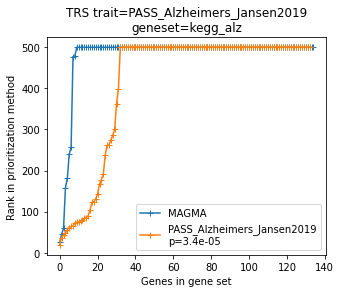

# silver_ldl_omim                n_gene=17/17
0.25442337098578316


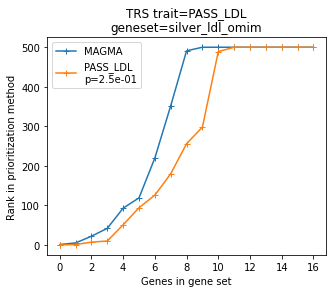

In [16]:
from scipy.stats import mannwhitneyu

gs_all_common = set(df_geneannot.index) & set(df_gene_corr.index)

for gs in dic_gs_map.keys():
    
    gs_list = dic_geneset_comp[gs].copy()
    gs_list = list(set(gs_list) & gs_all_common)
    print('# %-30s n_gene=%d/%d'%(gs, len(gs_list), len(dic_geneset_comp[gs])))
    tar_trait = dic_gs_map[gs].split(';')[0]
    
    # Rank based on TRS-correlation
    dic_trs_rank = {}
    for col in df_gene_corr.columns:
        if (tar_trait in col) | ('bl_' in col):
            temp_df = df_gene_corr[[col]].copy()
            temp_df.sort_values(by=col, inplace=True, ascending=False)
            temp_df['rank'] = np.arange(temp_df.shape[0])
    
            rank_trs = list(temp_df.loc[gs_list, 'rank'].values)
            rank_trs.sort()
            v_rank_trs = np.array(rank_trs).clip(max=500)
            dic_trs_rank[col.replace(tar_trait+';','')] = v_rank_trs
    
    # Rank based on MAGMA z-score
    temp_df = dic_magma[tar_trait].copy()
    temp_df.sort_values(by='z_score', inplace=True, ascending=False)
    temp_df['rank'] = np.arange(temp_df.shape[0])
    
    rank_magma = list(temp_df.loc[gs_list, 'rank'].values)
    rank_magma.sort()
    v_rank_magma = np.array(rank_magma).clip(max=500)    
    
    plt.figure(figsize=[5,4])
    plt.plot(np.arange(v_rank_magma.shape[0]), v_rank_magma,  '+-', label='MAGMA')

    for term in dic_trs_rank.keys():
        v_rank_trs = dic_trs_rank[term]
        _,p_val = mannwhitneyu(v_rank_magma, v_rank_trs, alternative='greater')
        plt.plot(np.arange(v_rank_trs.shape[0]), v_rank_trs, '+-', label='%s\np=%0.1e'%(term, p_val))
        print(p_val)
    plt.legend()
    plt.ylabel('Rank in prioritization method')
    plt.xlabel('Genes in gene set')
    plt.title('TRS trait=%s\ngeneset=%s'%(tar_trait, gs))
    plt.show()

### Lrp1 expression and TRS

In [25]:
ind_select = (dic_data_facs[tissue].obs['tissue']=='Liver')&\
                (dic_data_facs[tissue].obs['cell_ontology_class']=='hepatocyte')
adata_small = dic_data_facs[tissue][ind_select,:].copy()
df_plot = adata_small.obs[['age', 'mouse.id', 'sex', 'louvain', 'leiden']].copy()
df_plot['UMAP1'] = adata_small.obsm['X_umap'][:,0]
df_plot['UMAP2'] = adata_small.obsm['X_umap'][:,1]

dic_thres={'PASS_Alzheimers_Jansen2019':3,
           'PASS_HDL':3, 'PASS_LDL':3, 'UKB_460K.body_HEIGHTz':3}
for trait in TRAIT_LIST:
    temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
    temp_df['trs_ez'] = dic_trs['%s;trs_ez'%(trait)]
    df_plot['%s;trs_ez'%trait] = temp_df.loc[df_plot.index, 'trs_ez']
    df_plot['%s;binary'%trait] = ['high' if x>dic_thres[trait] else 'low' for x in df_plot['%s;trs_ez'%trait]]
    print('%s;binary'%trait, 'n_high=%d'%(df_plot['%s;binary'%trait]=='high').sum())

gene_list_plot = ['Lrp1']
for gene in gene_list_plot:
    temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
    temp_df[gene] = data_facs_ct[:,gene].X.toarray()
    df_plot[gene] = temp_df.loc[df_plot.index, gene]

PASS_Alzheimers_Jansen2019;binary n_high=116
PASS_HDL;binary n_high=196
PASS_LDL;binary n_high=388
UKB_460K.body_HEIGHTz;binary n_high=0


In [30]:
print(df_plot.groupby(['mouse.id', 'PASS_Alzheimers_Jansen2019;binary']).agg({'UMAP1':len}))
print(df_plot.groupby(['mouse.id', 'PASS_HDL;binary']).agg({'UMAP1':len}))
print(df_plot.groupby(['mouse.id', 'PASS_LDL;binary']).agg({'UMAP1':len}))

                                            UMAP1
mouse.id PASS_Alzheimers_Jansen2019;binary       
3_9_M    high                                13.0
         low                                 79.0
3_11_M   high                                15.0
         low                                133.0
3_56_F   high                                11.0
         low                                 71.0
3_57_F   high                                 5.0
         low                                 74.0
18_45_M  high                                14.0
         low                                 80.0
18_46_F  high                                17.0
         low                                 46.0
18_53_M  high                                14.0
         low                                212.0
24_58_M  high                                19.0
         low                                239.0
24_59_M  high                                 8.0
         low                                112.0


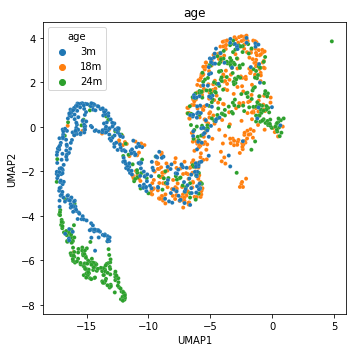

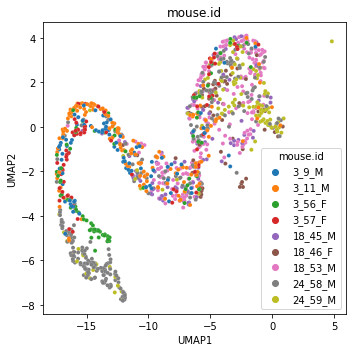

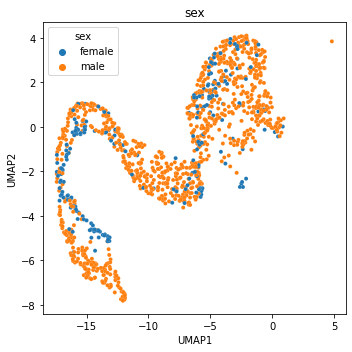

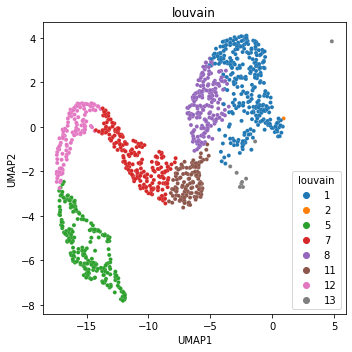

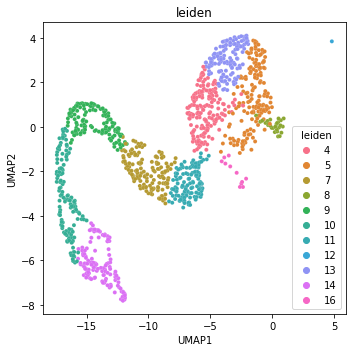

In [20]:
for term in ['age', 'mouse.id', 'sex', 'louvain', 'leiden']:
    plt.figure(figsize=[5,5])
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', 
                    hue=term, s=16, linewidth=0.1)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%(term))
    plt.tight_layout()
    plt.show()

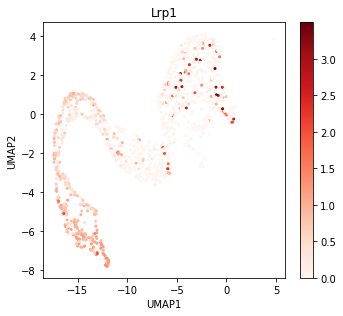

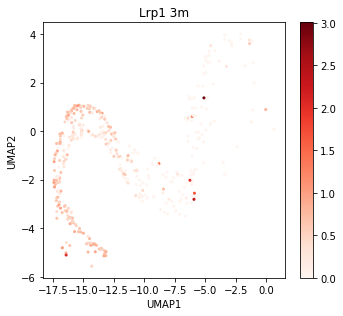

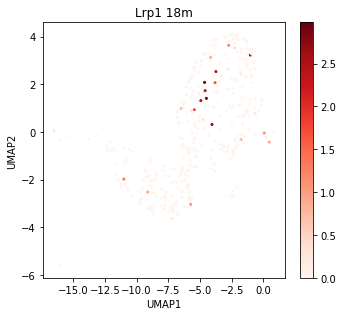

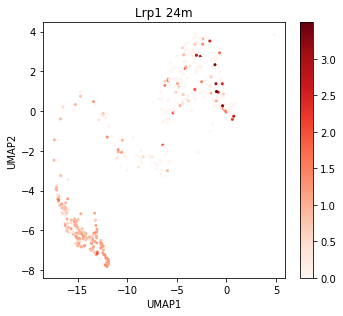

In [24]:
for gene in gene_list_plot:
    plt.figure(figsize=[5,4.5])
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[gene], cmap='Reds', s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%(gene))
    plt.tight_layout()
    plt.show()
    
    for age in ['3m', '18m', '24m']:
        ind_select = df_plot['age']==age
        plt.figure(figsize=[5,4.5])
        plt.scatter(df_plot.loc[ind_select, 'UMAP1'],
                    df_plot.loc[ind_select, 'UMAP2'],
                    c=df_plot.loc[ind_select, gene], cmap='Reds', s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s %s'%(gene, age))
        plt.tight_layout()
        plt.show()

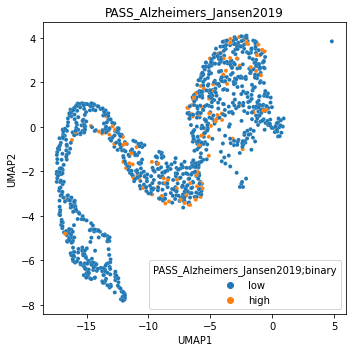

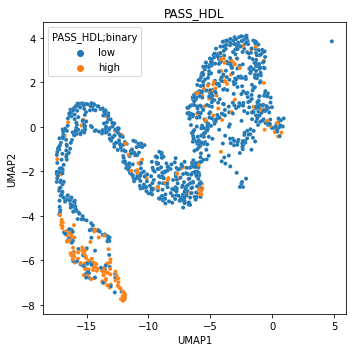

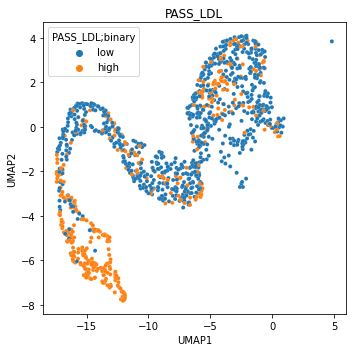

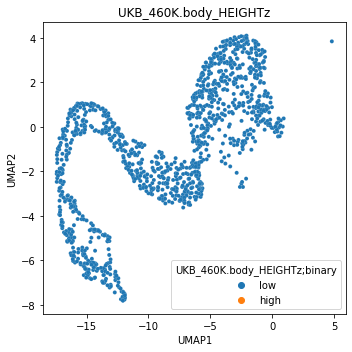

In [140]:
for trait in TRAIT_LIST:

    plt.figure(figsize=[5,5])
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', 
                    hue='%s;binary'%trait, hue_order=['low', 'high'], s=16, linewidth=0.1)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%(trait))
    plt.tight_layout()
    plt.show()

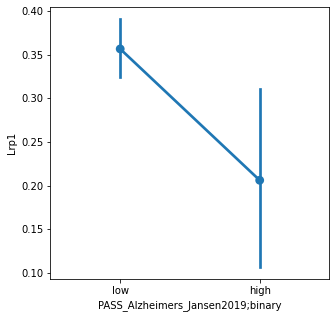

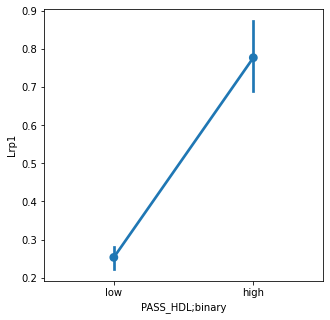

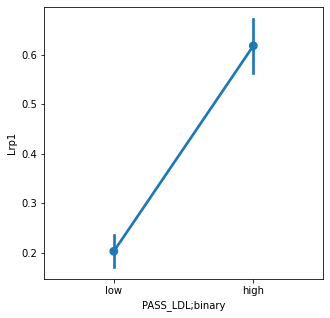

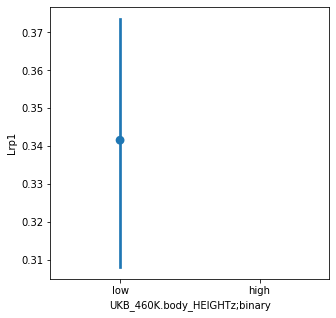

In [141]:
for trait in TRAIT_LIST:
    plt.figure(figsize=[5,5])
#     sns.violinplot(data=df_plot, x='%s;binary'%trait, y='Lrp1', order=['low', 'high'])
    sns.pointplot(data=df_plot, x='%s;binary'%trait, y='Lrp1', order=['low', 'high'])
    plt.show()
#     break

### Parition into two cell groups

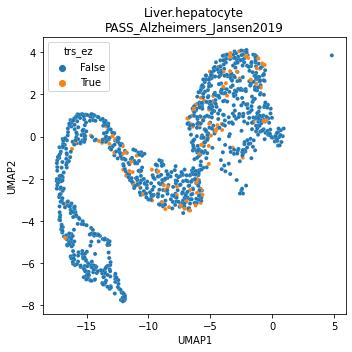

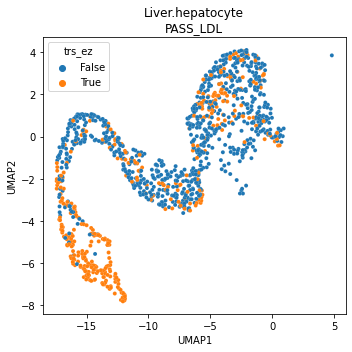

In [77]:
# Partition cells based on TRS 
ind_select = (dic_data_facs[tissue].obs['tissue']=='Liver')&\
                (dic_data_facs[tissue].obs['cell_ontology_class']=='hepatocyte')
adata_small = dic_data_facs[tissue][ind_select,:].copy()

df_plot = adata_small.obs[['louvain', 'leiden']].copy()
df_plot['UMAP1'] = adata_small.obsm['X_umap'][:,0]
df_plot['UMAP2'] = adata_small.obsm['X_umap'][:,1]


# Trait TRS plot
for trait in ['PASS_Alzheimers_Jansen2019', 'PASS_LDL']:

    temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
    temp_df['trs_ez'] = dic_trs['%s;trs_ez'%(trait)]
    df_plot['trs_ez'] = temp_df.loc[df_plot.index, 'trs_ez']

    df_plot['trs_ez'] = (df_plot['trs_ez']>3).astype('category')

    plt.figure(figsize=[5,5])
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', 
                    hue='trs_ez', palette='tab10', s=16, linewidth=0.1)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s\n%s'%(analyte, trait))
    plt.tight_layout()
    plt.show()

... storing 'tissue_celltype' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: hep_ref, hep_tar
var_group_labels: hep_tar


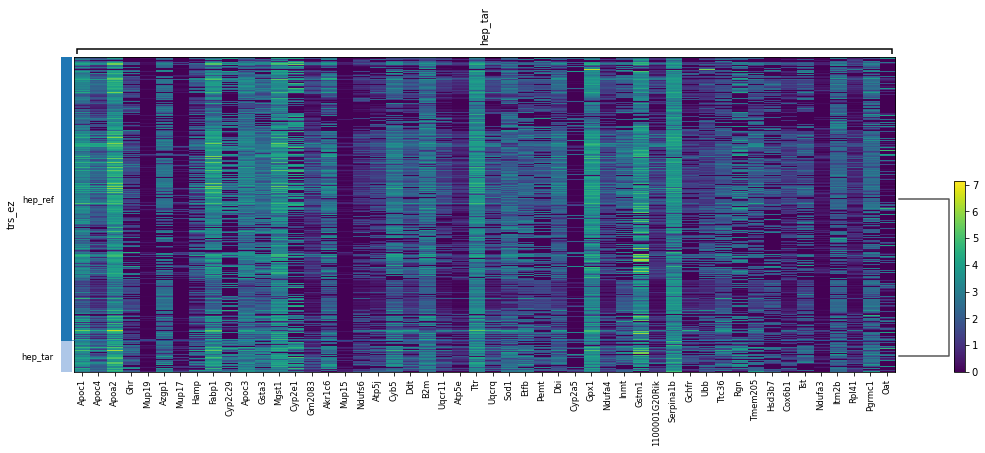

... storing 'tissue_celltype' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: hep_ref, hep_tar
var_group_labels: hep_tar


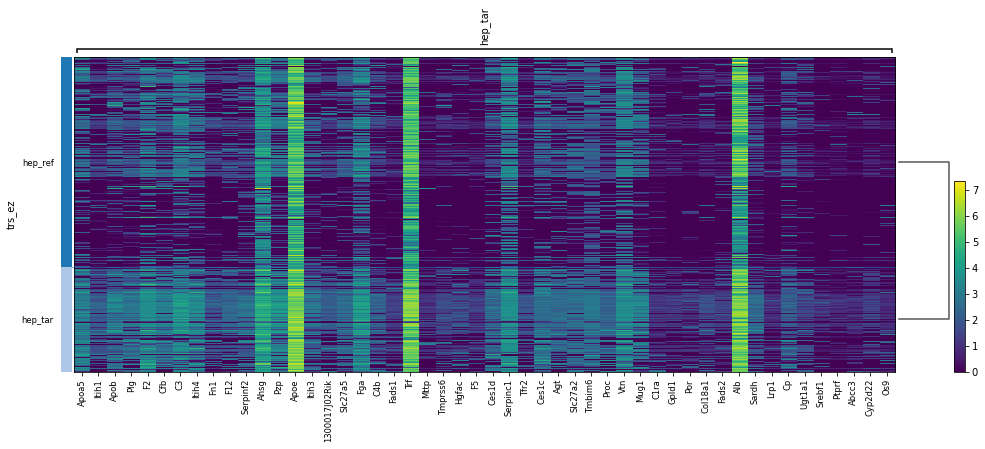

In [31]:
# Partition cells based on TRS 
def assign_group_name(x,y):
    if (x>3) & (y=='hepatocyte'):
        return 'hep_tar'
    if (x<=3) & (y=='hepatocyte'):
        return 'hep_ref'
    return 'other'

for trait in ['PASS_Alzheimers_Jansen2019', 'PASS_LDL']:
    
    data_facs_ct.obs['trs_ez'] = dic_trs['%s;trs_ez'%(trait)]
    ind_select = (data_facs_ct.obs['tissue']=='Liver') & \
                    (data_facs_ct.obs['cell_ontology_class']=='hepatocyte')
    adata_small = data_facs_ct[ind_select,:].copy()
    adata_small.obs['trs_ez'] = [assign_group_name(x,y)
                                 for x,y in zip(adata_small.obs['trs_ez'], adata_small.obs['cell_ontology_class'])]
    adata_small.obs['trs_ez'] = adata_small.obs['trs_ez'].astype('category')
    sc.tl.rank_genes_groups(adata_small, groupby='trs_ez', groups=['hep_tar'],
                            n_genes=50, method='wilcoxon')
    sc.pl.rank_genes_groups_heatmap(adata_small, groupby='trs_ez', n_genes=50)
    dic_geneset['binary_%s'%trait] = [x[0] for x in adata_small.uns['rank_genes_groups']['names']]

### Overlapping with genesets

### Expressoin of Lrp1

In [ ]:
gene_list_plot = ['Lrp1']

ind_select = (dic_data_facs[tissue].obs['tissue']=='Liver')&\
                (dic_data_facs[tissue].obs['cell_ontology_class']=='hepatocyte')
adata_small = dic_data_facs[tissue][ind_select,:].copy()

df_plot = pd.DataFrame(index=adata_small.obs.index)
df_plot['UMAP1'] = adata_small.obsm['X_umap'][:,0]
df_plot['UMAP2'] = adata_small.obsm['X_umap'][:,1]
    
for gene in gene_list_plot:
    df_plot[gene] = adata_small[:,gene].X.toarray()

    plt.figure(figsize=[5,4.5])
#     max_ = np.quantile(np.absolute(df_plot['trs_ez'].values), 0.99)
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[gene],
                cmap='Reds', s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%(gene))
    plt.tight_layout()
    plt.show()

In [ ]:
# Partition cells based on TRS 
ind_select = (dic_data_facs[tissue].obs['tissue']=='Liver')&\
                (dic_data_facs[tissue].obs['cell_ontology_class']=='hepatocyte')
adata_small = dic_data_facs[tissue][ind_select,:].copy()

df_plot = pd.DataFrame(index=adata_small.obs.index)
df_plot['UMAP1'] = adata_small.obsm['X_umap'][:,0]
df_plot['UMAP2'] = adata_small.obsm['X_umap'][:,1]
df_plot = df_plot.join(adata_small.obs[['age', 'sex', 'mouse.id']])

gene_list_plot = ['Lrp1']
for gene in gene_list_plot:
    df_plot[gene] = adata_small[:,gene].X.toarray()
    
# Trait TRS plot
for trait in ['PASS_Alzheimers_Jansen2019']:

    temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
    temp_df['trs_ez'] = dic_trs['%s;trs_ez'%(trait)]
    df_plot['trs_ez'] = temp_df.loc[df_plot.index, 'trs_ez']

    df_plot['subtype'] = (df_plot['trs_ez']>3.5).astype('category')

    plt.figure(figsize=[5,5])
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', 
                    hue='subtype', palette='tab10', s=16, linewidth=0.1)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s\n%s\nTRS z-score (centered at 0)'%(analyte, trait))
    plt.tight_layout()
    plt.show()
    
    print()